In [1]:
from torch.utils.data import Dataset
class ParallelLanguageDataset(Dataset):
    def __init__(self, data_path_1, data_path_2, tokenizer, max_len):
        self.data_1, self.data_2 = self.load_data(data_path_1, data_path_2)
        self.max_len = max_len
        self.tokenizer = tokenizer
 
    def __len__(self):
        return len(self.data_1)
 
    def __getitem__(self, item_idx):
        sent1 = str(self.data_1[item_idx])
        sent2 = str(self.data_2[item_idx])
        encoded_output_sent1 = self.tokenizer.encode_plus(
            sent1,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            return_tensors="pt",
            truncation=True
        )
        encoded_output_sent2 = self.tokenizer.encode_plus(
            sent2,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            return_tensors="pt",
            truncation=True
        )
 
        encoded_output_sent1["attention_mask"][
            encoded_output_sent1["attention_mask"] == 1
        ] = 2
        encoded_output_sent1["attention_mask"][
            encoded_output_sent1["attention_mask"] == 0
        ] = True
        encoded_output_sent1["attention_mask"][
            encoded_output_sent1["attention_mask"] == 2
        ] = False
        encoded_output_sent1["attention_mask"] = encoded_output_sent1[
            "attention_mask"
        ].type(torch.bool)
 
        encoded_output_sent2["attention_mask"][
            encoded_output_sent2["attention_mask"] == 1
        ] = 2
        encoded_output_sent2["attention_mask"][
            encoded_output_sent2["attention_mask"] == 0
        ] = True
        encoded_output_sent2["attention_mask"][
            encoded_output_sent2["attention_mask"] == 2
        ] = False
        encoded_output_sent2["attention_mask"] = encoded_output_sent2[
            "attention_mask"
        ].type(torch.bool)
 
        return_dict = {
            "ids1": encoded_output_sent1["input_ids"].flatten(),
            "ids2": encoded_output_sent2["input_ids"].flatten(),
            "masks_sent1": encoded_output_sent1["attention_mask"].flatten(),
            "masks_sent2": encoded_output_sent2["attention_mask"].flatten(),
        }
        return return_dict
 
    def load_data(self, data_path_1, data_path_2):
        with open(data_path_1, "r") as f:
            data_1 = f.read().splitlines()[1:200]
        with open(data_path_2, "r") as f:
            data_2 = f.read().splitlines()[1:200]
        return data_1, data_2

In [2]:
!pip install einops

In [3]:
import math
from einops import rearrange

import torch
from torch import nn


class LanguageTransformer(nn.Module):
    def __init__(
        self,
        vocab_size,
        d_model,
        nhead,
        num_encoder_layers,
        num_decoder_layers,
        dim_feedforward,
        max_seq_length,
        pos_dropout,
        trans_dropout,
    ):
        super().__init__()
        self.d_model = d_model
        self.embed_src = nn.Embedding(vocab_size, d_model)
        self.embed_tgt = nn.Embedding(vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, pos_dropout, max_seq_length)

        self.transformer = nn.Transformer(
            d_model,
            nhead,
            num_encoder_layers,
            num_decoder_layers,
            dim_feedforward,
            trans_dropout,
        )
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(
        self,
        src,
        tgt,
        src_key_padding_mask,
        tgt_key_padding_mask,
        memory_key_padding_mask,
        tgt_mask,
    ):
        src = rearrange(src, "n s -> s n")
        tgt = rearrange(tgt, "n t -> t n")
        src = self.pos_enc(self.embed_src(src) * math.sqrt(self.d_model))
        tgt = self.pos_enc(self.embed_tgt(tgt) * math.sqrt(self.d_model))

        output = self.transformer(
            src,
            tgt,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask,
        )
        output = rearrange(output, "t n e -> n t e")
        return self.fc(output)


# Source: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
cd /content/drive/MyDrive/Data/

/content/drive/MyDrive/Data


In [6]:
'''A wrapper class for optimizer '''
import numpy as np


# From https://github.com/jadore801120/attention-is-all-you-need-pytorch/blob/master/transformer/Optim.py
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(d_model, -0.5)

    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        "Zero out the gradients by the inner optimizer"
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_current_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr
            

In [7]:
!pip install transformers

     |████████████████████████████████| 2.1MB 5.8MB/s 
     |████████████████████████████████| 901kB 19.0MB/s 
     |████████████████████████████████| 3.3MB 28.8MB/s 


In [8]:
def train(train_loader, valid_loader, model, optim, criterion, num_epochs):
    print_every = 5
    model.train()

    lowest_val = 1e9
    train_losses = []
    val_losses = []
    total_step = 0
    print("-" * 100)
    print("Starting Training")
    print("-" * 100)

    for epoch in range(num_epochs):
        pbar = tqdm(total=print_every, leave=False)
        total_loss = 0
        train_loss = 0

        for step, data_dict in enumerate(iter(train_loader)):
            total_step += 1
            src, tgt, src_key_padding_mask, tgt_key_padding_mask = (
                data_dict["ids1"],
                data_dict["ids2"],
                data_dict["masks_sent1"],
                data_dict["masks_sent2"],
            )
            src, src_key_padding_mask = src.to("cuda"), src_key_padding_mask.to("cuda")
            tgt, tgt_key_padding_mask = tgt.to("cuda"), tgt_key_padding_mask.to("cuda")

            memory_key_padding_mask = src_key_padding_mask.clone()
            tgt_inp, tgt_out = tgt[:, :-1], tgt[:, 1:]
            tgt_mask = gen_nopeek_mask(tgt_inp.shape[1]).to("cuda")

            optim.zero_grad()
            outputs = model(
                src,
                tgt_inp,
                src_key_padding_mask,
                tgt_key_padding_mask[:, :-1],
                memory_key_padding_mask,
                tgt_mask,
            )
            loss = criterion(
                rearrange(outputs, "b t v -> (b t) v"),
                rearrange(tgt_out, "b o -> (b o)"),
            )

            loss.backward()
            optim.step_and_update_lr()
            train_loss += loss.item()
            total_loss += loss.item()
            pbar.update(1)
            if step % print_every == print_every - 1:
                pbar.close()
                print(
                    f"Epoch [{epoch + 1} / {num_epochs}] \t Step [{step + 1} / {len(train_loader)}] \t "
                    f"Train Loss: {total_loss / print_every}"
                )
                total_loss = 0
                pbar = tqdm(total=print_every, leave=False)
        pbar.close()
        val_loss = validate(valid_loader, model, criterion)
        val_losses.append(val_loss)
        train_losses.append(train_loss/len(train_loader))
        if val_loss < lowest_val:
            lowest_val = val_loss
            torch.save(model, "Output/transformer.pth")
        print(f"Val Loss: {val_loss}")
    return train_losses, val_losses

In [9]:
def validate(valid_loader, model, criterion):
    pbar = tqdm(total=len(iter(valid_loader)), leave=False)
    model.eval()

    total_loss = 0
    for step, data_dict in enumerate(iter(valid_loader)):
        with torch.no_grad():
            src, tgt, src_key_padding_mask, tgt_key_padding_mask = (
                data_dict["ids1"],
                data_dict["ids2"],
                data_dict["masks_sent1"],
                data_dict["masks_sent2"],
            )
            src, src_key_padding_mask = src.to("cuda"), src_key_padding_mask.to("cuda")
            tgt, tgt_key_padding_mask = tgt.to("cuda"), tgt_key_padding_mask.to("cuda")
            memory_key_padding_mask = src_key_padding_mask.clone()
            tgt_inp = tgt[:, :-1]
            tgt_out = tgt[:, 1:].contiguous()
            tgt_mask = gen_nopeek_mask(tgt_inp.shape[1]).to("cuda")
            outputs = model(
                src,
                tgt_inp,
                src_key_padding_mask,
                tgt_key_padding_mask[:, :-1],
                memory_key_padding_mask,
                tgt_mask,
            )
            loss = criterion(
                rearrange(outputs, "b t v -> (b t) v"),
                rearrange(tgt_out, "b o -> (b o)"),
            )
            total_loss += loss.item()
            pbar.update(1)

    pbar.close()
    model.train()
    return total_loss / len(valid_loader)


In [10]:
def gen_nopeek_mask(length):
    mask = rearrange(torch.triu(torch.ones(length, length)) == 1, "h w -> w h")
    mask = (
        mask.float()
        .masked_fill(mask == 0, float("-inf"))
        .masked_fill(mask == 1, float(0.0))
    )
    return mask


In [11]:
import numpy as np
import torch
import torch.nn as nn
import transformers
from pathlib import Path
from einops import rearrange
from tqdm import tqdm
from transformers import RobertaTokenizer
from torch.optim import Adam
from torch.utils.data import DataLoader
import os
import logging
logging.basicConfig(level=logging.ERROR)

num_epochs = 20
batch_size = 8
max_seq_length = 96
d_model = 512
num_encoder_layers = 6
num_decoder_layers = 6
dim_feedforward = 2048
nhead = 8
pos_dropout = 0.1
trans_dropout = 0.1
n_warmup_steps = 2000
PRE_TRAINED_MODEL_NAME = "distilroberta-base"

train_losses = []
val_losses = []

In [12]:
 
project_path = ""
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
train_dataset = ParallelLanguageDataset(
        project_path + "raw/es/train.txt",
        project_path + "raw/en/train.txt",
        tokenizer,
        max_seq_length,
)
train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
    )
valid_dataset = ParallelLanguageDataset(
        project_path + "raw/es/val.txt",
        project_path + "raw/en/val.txt",
        tokenizer,
        max_seq_length,
    )
valid_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
    )
 
model = LanguageTransformer(
        tokenizer.vocab_size,
        d_model,
        nhead,
        num_encoder_layers,
        num_decoder_layers,
        dim_feedforward,
        max_seq_length,
        pos_dropout,
        trans_dropout,
  ).to("cuda")
for p in model.parameters():
  if p.dim() > 1:
    nn.init.xavier_normal_(p)
 
optim = ScheduledOptim(Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-09), d_model, n_warmup_steps)
criterion = nn.CrossEntropyLoss(ignore_index=0)
train_losses, val_losses = train(
      train_loader, valid_loader, model, optim, criterion, num_epochs
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/5 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Starting Training
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [1 / 20] 	 Step [5 / 25] 	 Train Loss: 10.776235580444336


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1 / 20] 	 Step [10 / 25] 	 Train Loss: 10.580711364746094


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1 / 20] 	 Step [15 / 25] 	 Train Loss: 10.209757423400879


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1 / 20] 	 Step [20 / 25] 	 Train Loss: 9.86198787689209


Epoch [1 / 20] 	 Step [25 / 25] 	 Train Loss: 9.712678718566895


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 9.58159511566162


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [2 / 20] 	 Step [5 / 25] 	 Train Loss: 9.614302825927734


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [2 / 20] 	 Step [10 / 25] 	 Train Loss: 9.217145347595215


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [2 / 20] 	 Step [15 / 25] 	 Train Loss: 9.235702514648438


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [2 / 20] 	 Step [20 / 25] 	 Train Loss: 9.173331260681152


Epoch [2 / 20] 	 Step [25 / 25] 	 Train Loss: 9.14172134399414


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 9.012376365661622


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [3 / 20] 	 Step [5 / 25] 	 Train Loss: 9.03467082977295


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [3 / 20] 	 Step [10 / 25] 	 Train Loss: 8.5591251373291


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [3 / 20] 	 Step [15 / 25] 	 Train Loss: 8.461700057983398


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [3 / 20] 	 Step [20 / 25] 	 Train Loss: 8.76293067932129


Epoch [3 / 20] 	 Step [25 / 25] 	 Train Loss: 8.63708438873291


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 8.411805782318115


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [4 / 20] 	 Step [5 / 25] 	 Train Loss: 8.34701747894287


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [4 / 20] 	 Step [10 / 25] 	 Train Loss: 8.31210765838623


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [4 / 20] 	 Step [15 / 25] 	 Train Loss: 7.89991340637207


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [4 / 20] 	 Step [20 / 25] 	 Train Loss: 7.714189910888672


Epoch [4 / 20] 	 Step [25 / 25] 	 Train Loss: 7.359482860565185


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 7.560289497375488


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [5 / 20] 	 Step [5 / 25] 	 Train Loss: 7.3396422386169435


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [5 / 20] 	 Step [10 / 25] 	 Train Loss: 7.2484588623046875


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [5 / 20] 	 Step [15 / 25] 	 Train Loss: 6.621540927886963


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [5 / 20] 	 Step [20 / 25] 	 Train Loss: 6.89579496383667


Epoch [5 / 20] 	 Step [25 / 25] 	 Train Loss: 6.484585380554199


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 6.503200206756592


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [6 / 20] 	 Step [5 / 25] 	 Train Loss: 6.282202339172363


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [6 / 20] 	 Step [10 / 25] 	 Train Loss: 6.069911670684815


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [6 / 20] 	 Step [15 / 25] 	 Train Loss: 5.709705638885498


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [6 / 20] 	 Step [20 / 25] 	 Train Loss: 5.503112125396728


Epoch [6 / 20] 	 Step [25 / 25] 	 Train Loss: 5.2706324577331545


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 5.436994152069092


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [7 / 20] 	 Step [5 / 25] 	 Train Loss: 5.063226985931396


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [7 / 20] 	 Step [10 / 25] 	 Train Loss: 4.935116958618164


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [7 / 20] 	 Step [15 / 25] 	 Train Loss: 4.952196216583252


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [7 / 20] 	 Step [20 / 25] 	 Train Loss: 4.390484046936035


Epoch [7 / 20] 	 Step [25 / 25] 	 Train Loss: 4.195209980010986


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 4.609533605575561


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [8 / 20] 	 Step [5 / 25] 	 Train Loss: 4.20097393989563


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [8 / 20] 	 Step [10 / 25] 	 Train Loss: 4.011663103103638


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [8 / 20] 	 Step [15 / 25] 	 Train Loss: 3.9669708251953124


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [8 / 20] 	 Step [20 / 25] 	 Train Loss: 3.7958351135253907


Epoch [8 / 20] 	 Step [25 / 25] 	 Train Loss: 3.845748043060303


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 4.126723823547363


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [9 / 20] 	 Step [5 / 25] 	 Train Loss: 3.457754611968994


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [9 / 20] 	 Step [10 / 25] 	 Train Loss: 3.945321035385132


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [9 / 20] 	 Step [15 / 25] 	 Train Loss: 3.421115493774414


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [9 / 20] 	 Step [20 / 25] 	 Train Loss: 3.547894763946533


Epoch [9 / 20] 	 Step [25 / 25] 	 Train Loss: 3.187445783615112


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.792938575744629


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [10 / 20] 	 Step [5 / 25] 	 Train Loss: 3.4371283054351807


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [10 / 20] 	 Step [10 / 25] 	 Train Loss: 2.925659942626953


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [10 / 20] 	 Step [15 / 25] 	 Train Loss: 3.733755588531494


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [10 / 20] 	 Step [20 / 25] 	 Train Loss: 3.184948468208313


Epoch [10 / 20] 	 Step [25 / 25] 	 Train Loss: 2.8475631713867187


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.6283295440673826


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [11 / 20] 	 Step [5 / 25] 	 Train Loss: 3.0696643352508546


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [11 / 20] 	 Step [10 / 25] 	 Train Loss: 3.1777130603790282


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [11 / 20] 	 Step [15 / 25] 	 Train Loss: 3.104042959213257


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [11 / 20] 	 Step [20 / 25] 	 Train Loss: 3.0605821132659914


Epoch [11 / 20] 	 Step [25 / 25] 	 Train Loss: 2.9393792152404785


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.5354142570495606


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [12 / 20] 	 Step [5 / 25] 	 Train Loss: 3.238702154159546


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [12 / 20] 	 Step [10 / 25] 	 Train Loss: 3.024519991874695


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [12 / 20] 	 Step [15 / 25] 	 Train Loss: 2.809674072265625


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [12 / 20] 	 Step [20 / 25] 	 Train Loss: 3.0356064319610594


Epoch [12 / 20] 	 Step [25 / 25] 	 Train Loss: 2.837361192703247


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.4852204608917234


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [13 / 20] 	 Step [5 / 25] 	 Train Loss: 2.967295026779175


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [13 / 20] 	 Step [10 / 25] 	 Train Loss: 2.9375255584716795


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [13 / 20] 	 Step [15 / 25] 	 Train Loss: 2.793523669242859


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [13 / 20] 	 Step [20 / 25] 	 Train Loss: 3.1111324787139893


Epoch [13 / 20] 	 Step [25 / 25] 	 Train Loss: 2.7547134876251222


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.454493131637573


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [14 / 20] 	 Step [5 / 25] 	 Train Loss: 3.0407012462615968


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [14 / 20] 	 Step [10 / 25] 	 Train Loss: 2.643612599372864


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [14 / 20] 	 Step [15 / 25] 	 Train Loss: 3.0366936683654786


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [14 / 20] 	 Step [20 / 25] 	 Train Loss: 2.7849238872528077


Epoch [14 / 20] 	 Step [25 / 25] 	 Train Loss: 2.714126777648926


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.379211301803589


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [15 / 20] 	 Step [5 / 25] 	 Train Loss: 2.562212109565735


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [15 / 20] 	 Step [10 / 25] 	 Train Loss: 2.588061046600342


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [15 / 20] 	 Step [15 / 25] 	 Train Loss: 2.907008671760559


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [15 / 20] 	 Step [20 / 25] 	 Train Loss: 3.025657606124878


Epoch [15 / 20] 	 Step [25 / 25] 	 Train Loss: 2.7226469039916994


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.343345618247986


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [16 / 20] 	 Step [5 / 25] 	 Train Loss: 3.1127833843231203


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [16 / 20] 	 Step [10 / 25] 	 Train Loss: 2.983728766441345


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [16 / 20] 	 Step [15 / 25] 	 Train Loss: 2.387980556488037


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [16 / 20] 	 Step [20 / 25] 	 Train Loss: 2.688579225540161


Epoch [16 / 20] 	 Step [25 / 25] 	 Train Loss: 2.2122125387191773


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.280109930038452


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [17 / 20] 	 Step [5 / 25] 	 Train Loss: 2.185368800163269


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [17 / 20] 	 Step [10 / 25] 	 Train Loss: 3.135618495941162


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [17 / 20] 	 Step [15 / 25] 	 Train Loss: 2.2911065340042116


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [17 / 20] 	 Step [20 / 25] 	 Train Loss: 2.6254363775253298


Epoch [17 / 20] 	 Step [25 / 25] 	 Train Loss: 2.6044359683990477


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.225482535362244


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [18 / 20] 	 Step [5 / 25] 	 Train Loss: 2.4115493297576904


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [18 / 20] 	 Step [10 / 25] 	 Train Loss: 2.5324386835098265


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [18 / 20] 	 Step [15 / 25] 	 Train Loss: 2.667938780784607


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [18 / 20] 	 Step [20 / 25] 	 Train Loss: 2.358997416496277


Epoch [18 / 20] 	 Step [25 / 25] 	 Train Loss: 2.2248425006866457


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.1593219661712646


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [19 / 20] 	 Step [5 / 25] 	 Train Loss: 2.1534096717834474


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [19 / 20] 	 Step [10 / 25] 	 Train Loss: 2.148365330696106


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [19 / 20] 	 Step [15 / 25] 	 Train Loss: 2.6073340654373167


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [19 / 20] 	 Step [20 / 25] 	 Train Loss: 2.2833115816116334


Epoch [19 / 20] 	 Step [25 / 25] 	 Train Loss: 2.361609363555908


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.1138194227218627


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [20 / 20] 	 Step [5 / 25] 	 Train Loss: 2.0291672706604005


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [20 / 20] 	 Step [10 / 25] 	 Train Loss: 2.2349977493286133


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [20 / 20] 	 Step [15 / 25] 	 Train Loss: 2.830618476867676


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [20 / 20] 	 Step [20 / 25] 	 Train Loss: 1.7423967123031616


Epoch [20 / 20] 	 Step [25 / 25] 	 Train Loss: 2.053290843963623


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.0630029296875


In [13]:
print(len(train_losses))
print(len(val_losses))

20
20


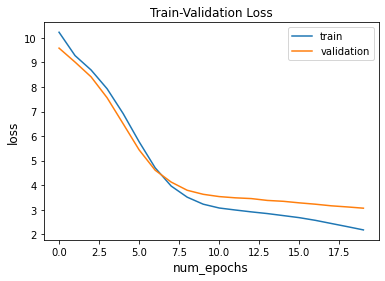

In [14]:
 
import matplotlib.pyplot as plt
fig = plt.figure()
plt.title("Train-Validation Loss")
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='validation')
 
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')
print()